# Setting Up Environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -Uqq fastai fastbook nbdev

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr onnxruntime onnx nbdev wandb

In [4]:
!nvidia-smi

Mon May 29 06:00:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import pandas as pd
import numpy as np
import torch
from fastai.metrics import accuracy
torch.cuda.is_available()
from fastai.vision.all import *
from fastcore.parallel import *

import torch
import glob2, numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive/MasterCourse/Leaf Disease Detection

/content/drive/My Drive/MasterCourse/Leaf Disease Detection


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
df = pd.read_csv('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/final-data.csv')
df.head()

,Image,Name,Status,Disease Name
0,augimg/Maple___powdery_mildew/yCapture.PNG 7.PNG,Maple,diseased,powdery_mildew
1,augimg/Maple___powdery_mildew/xistockphoto-1335217312-612x612.jpg,Maple,diseased,powdery_mildew
2,augimg/Maple___powdery_mildew/cmildewonbigleafmaplescloseup.jpg,Maple,diseased,powdery_mildew
3,augimg/Maple___powdery_mildew/bCapture.PNG 28.PNG,Maple,diseased,powdery_mildew
4,augimg/Maple___powdery_mildew/zimages.jpg,Maple,diseased,powdery_mildew


# **Multi Target Classification**

In [ ]:

labels = pd.read_csv('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/final-data.csv')

with tf.device('/device:GPU:0'):

  dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                      splitter=RandomSplitter(valid_pct=.2,seed=42),
                      get_x=ColReader('Image'),
                      get_y=ColReader(['Name','Status','Disease Name']),
                      item_tfms=Resize(300),
                      
      )
  dls = dblock.dataloaders(labels, bs=32)

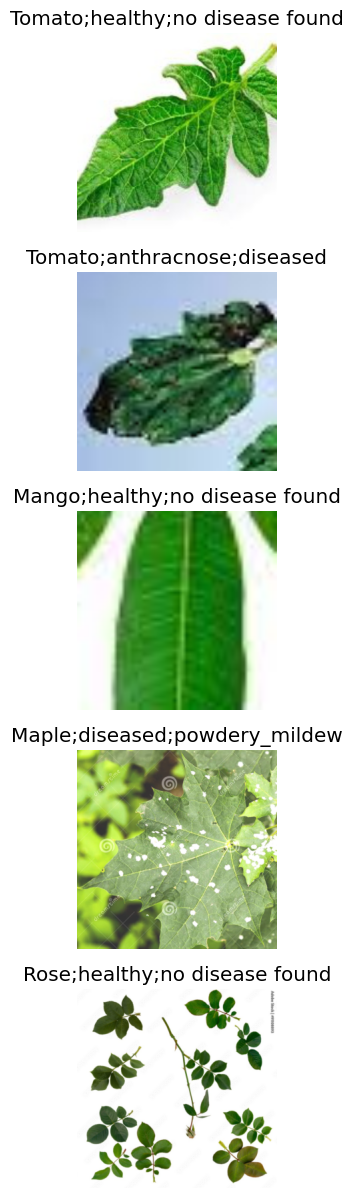

In [ ]:
with tf.device('/device:GPU:0'):
  dls.train.show_batch(max_n=5,nrows=5)

# Training resnet-34

In [ ]:
with tf.device('/device:GPU:0'):
  learn = vision_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.freeze()

SuggestedLRs(valley=0.0030199517495930195)

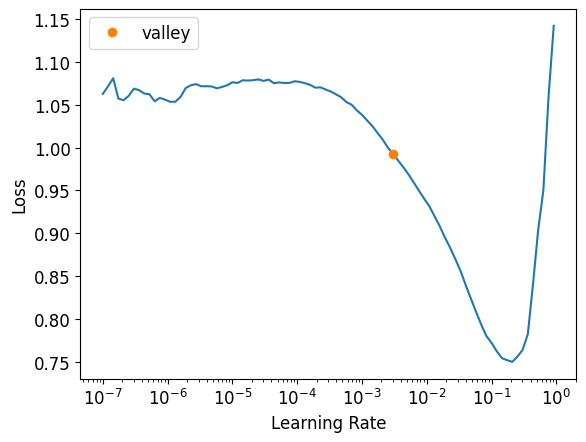

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(1,0.0030199517495930195)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.100458,0.039079,0.988683,0.881293,0.911555,16:41


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.00019054606673307717)

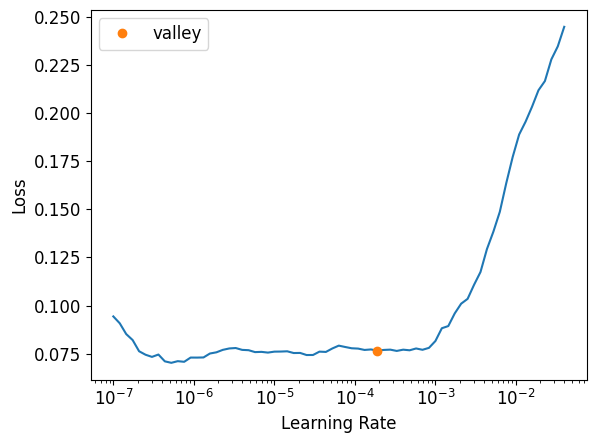

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(3,0.00019054606673307717)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.037693,0.010916,0.996674,0.919500,0.920694,02:14
1,0.019383,0.004816,0.998834,0.927352,0.929401,02:16
2,0.008222,0.002112,0.999863,0.932688,0.932644,02:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


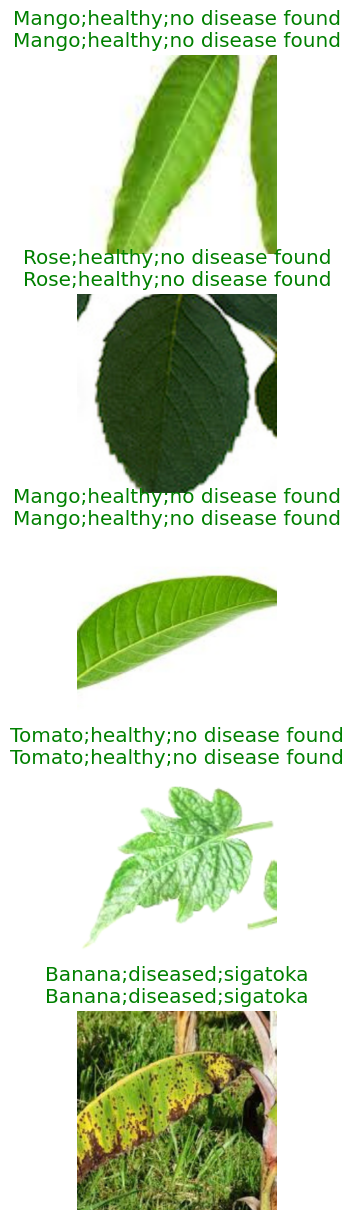

In [ ]:
with tf.device('/device:GPU:0'):  
  learn.show_results(figsize=(15,15),max_n=5,nrows=5)

# Training resnet-18

In [ ]:
with tf.device('/device:GPU:0'):
  learn = vision_learner(dls, resnet18, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
learn.freeze()

SuggestedLRs(valley=0.0008317637839354575)

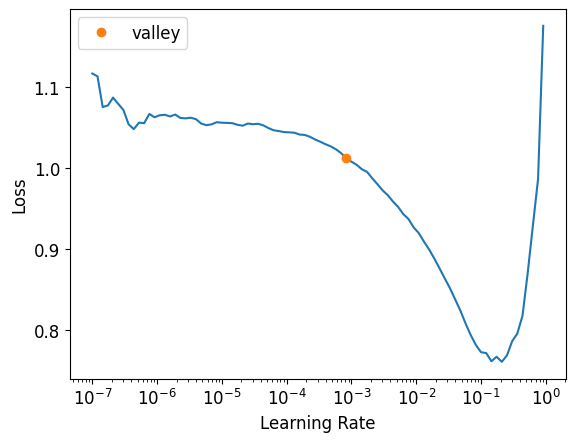

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(1,0.0008317637839354575)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.378255,0.224275,0.945988,0.739174,0.655514,01:35


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.0002754228771664202)

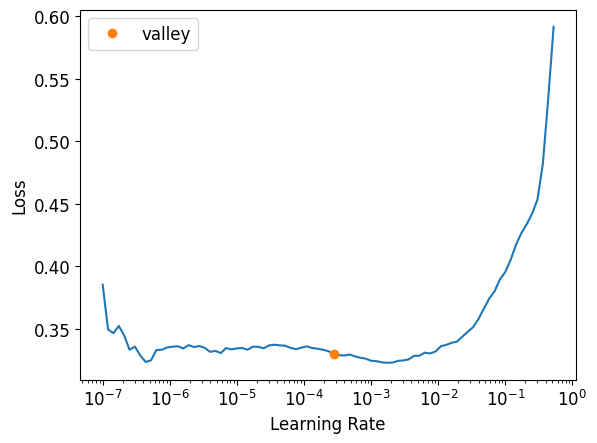

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(3,0.0002754228771664202)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.191205,0.090231,0.982065,0.865305,0.843375,01:42
1,0.071927,0.024093,0.996914,0.918861,0.915247,01:38
2,0.038500,0.014685,0.998834,0.928576,0.930272,01:38


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

In [ ]:
import pickle
with tf.device('/device:GPU:0'):
  learn.export('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/multi_target_resnet18.pkl',)

# Inference

In [10]:
model_path = '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/multi_target_resnet18.pkl'
learner_inf = load_learner(model_path)

In [17]:
preds = learner_inf.predict('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/test-images/maple.jpg')
print(preds)

(['Maple', 'anthracnose', 'diseased'], tensor([False, False, False, False,  True, False, False, False,  True,  True,
        False, False, False, False, False]), tensor([0.0285, 0.0069, 0.0057, 0.0033, 1.0000, 0.0258, 0.0032, 0.0053, 0.9794,
        0.9982, 0.0013, 0.0274, 0.0020, 0.0139, 0.0162]))


In [44]:
learner_inf.model.hf_model

AttributeError: ignored

# Best Model Size Compression by ONNX

In [18]:
dummy_input = torch.randn(1, 3, 300, 300)
torch.onnx.export(learner_inf.model, dummy_input, '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/model.onnx', opset_version=13)

In [19]:
import onnx

onnx_model = onnx.load('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/model.onnx')

onnx.checker.check_model(onnx_model)

In [20]:
import onnxruntime
from onnxruntime import *
from onnxruntime.quantization import quantize_dynamic, QuantType

ort_session = onnxruntime.InferenceSession('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/model.onnx')
quantized_model_path = '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/quantized_model.onnx'
quantize_dynamic(
    '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/model.onnx',
    quantized_model_path,
    weight_type=QuantType.QUInt8,
)

# Deploy to huggingface using Gradio

In [21]:
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 10.1 MB/s eta 0

In [22]:
import gradio as gr
from fastai.vision.all import load_learner
from fastai import *
import torch
import os
from PIL import Image

In [39]:
model_path = '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/models/multi_target_resnet18.pkl'
model = load_learner(model_path)
print(model.predict('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/test-images/banana-sigatoka.jpg'))

(['Banana', 'diseased', 'sigatoka'], tensor([False,  True, False, False, False, False, False, False, False,  True,
        False, False, False, False,  True]), tensor([2.7364e-03, 1.0000e+00, 2.5449e-03, 6.5160e-04, 1.1140e-03, 1.1674e-03,
        3.0298e-04, 5.1664e-04, 1.4444e-04, 1.0000e+00, 6.1888e-07, 9.8631e-04,
        6.0702e-07, 1.0715e-03, 1.0000e+00]))


In [48]:
def result(path):    
    pred,_,probability = model.predict(path)
    arr = ['Name','Status','Disease Name']
    vals = ['', '', '']

    names = ['Maple', 'Banana', 'Cucumber', 'Mango', 'Maple', 'Pepper', 'Rose', 'Tomato']
    status = ['diseased', 'no disease found']

    for x in pred:
      if x in names:
        vals[0] = x.capitalize()
      elif x in status:
        vals[1] = x.capitalize()
      elif x == 'healthy':
        vals[2] = 'None'
      else:
        vals[2] = x.capitalize()
      
    return f'{arr[0]}:\t{vals[0]}\n{arr[1]}:\t{vals[1]}\n{arr[2]}:\t{vals[2]}\n'

print(result('/content/drive/My Drive/MasterCourse/Leaf Disease Detection/test-images/maple.jpg'))

Name:	Maple
Status:	Diseased
Disease Name:	Anthracnose



In [ ]:
path = '/content/drive/My Drive/MasterCourse/Leaf Disease Detection/test-images/'

image_path = []

for i in os.listdir(path):
  image_path.append(path+i) 

image = gr.inputs.Image(shape =(300,300))
label = gr.outputs.Label()

iface = gr.Interface(fn=result, inputs=image, outputs='text', examples = image_path)
iface.launch(inline = True)